<a href="https://colab.research.google.com/github/KY-39/platform_udt3/blob/main/%D0%A0%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D0%B8_%D0%BE%D0%B4%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%D0%BD%D1%8B%D0%B5_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D1%81%D0%BB%D0%BE%D0%B8_%D0%B2_%D1%81%D0%B5%D1%82%D1%8F%D1%85_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ООО "Университет Цифровых Технологий платформа 3"

##Домашнее задание к уроку "Рекуррентные и одномерные сверточные слои в сетях обработки текстов."

Определение тональности текста. Цель состоит в том, чтобы определить тональность текста на основе предоставленных данных. Данные представляют набор текстовых данных отзывов на покупку мобильных телефонов и аксессуаров. Где отзывы определены по 5-ти бальной оценке где 5 — максимально положительный отзыв, 1 — максимально отрицательный отзыв.

Загрузите из датасета текстовую базу отзывов на покупку мобильных телефонов и аксессуаров, а также базу для тестирования. Подайте дата сет в нейронную сеть, постаравшись добиться максимальной точности распознавания. 

Для улучшения обучения можно использовать:  
1. Выбрать модель сверточную или рекуррентную сеть. 
2. Использовать дополнительные методы, не рассмотренные в занятиях, слои, функции активации, менять параметры оптимизатора  и прочие гипер параметры. 

Предсказание Вашей сети необходимо отправить в виде специального файла с расширением csv, чтобы войти в рейтинговую таблицу соревнования. Ответ можно улучшить и подавать результат несколько раз.

Содержание датасета: Набор текстовых данных содержат отзывы покупателей на покупку мобильных телефонов и аксессуаров и анализ тональности по 5-ти бальной шкале.

###Инициализация необходимых библиотек.

In [1]:
import numpy as np # модуль для загрузки файлов в colab
import pandas as pd #библиотека для работы с таблицами pandas
from google.colab import files #библиотека для работы с массивами данных
import json

from sklearn.model_selection import train_test_split
import tensorflow as tf # импортируем tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer,tokenizer_from_json
from tensorflow.keras.utils import plot_model, get_file, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,load_model
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
import zipfile # для работы с архивами zip
import csv # импортируем модуль для удобной работы с файлами
import matplotlib as mpl
import matplotlib.pyplot as plt #Отрисовка изображений
#Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline
# устанавливаем свежий Kaggle API
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=d492df0d47a6b9d6630d01c7bd23b8123176cd72dce5de6db21279529e730aab
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Ссылка на сревнование: https://www.kaggle.com/t/36855c178a164eb884324da040b0caad


Устанавливаем ключ Каггл, чтобы участвовать в соревнованиях. Это нужно сделать один раз.
Нужно зарегистрироваться на Каггл (https://www.kaggle.com/) и скачать ключ для взаимодействия с API соревновательной системы Каггла. После регистрации, справа появятся Ваши имя и фамилия - ссылка на персональную страницу. Нажмите на них. Когда страница загрузится, справа увидите Account. Нажимаете на надпись, затем прокручиваете страницу вниз, до вкладки API, там нажимаете Create New API Token. Ключ - это файл kaggle.json, который скачается после нажатия. Нужно скопировать его в папку Google Drive, предварительно её создав: My Drive/datasets/kaggle/ (из Колаба её адрес, который будем указывать для загрузки, такой: /content/drive/My Drive/datasets/kaggle/).

###Загрузка и знакомство с данными

In [3]:
def Init_Kaggle():
    try:
        # Создаём правильную папку для ключа Каггл
        # в Колабе, она должна быть такой по требованию Каггл
        !mkdir ~/.kaggle
        # переходим в папку, теперь это путь по умолчанию
        %cd ~/.kaggle
        # запускаем - подключаем Google Drive - будем скачивать с него, так намного быстрее и удобнее
        # после запуска переходим по ссылке, которая появится, для идентификации
        # копируем оттуда код authorization code и вставляем здесь в окошко
        drive.mount('/content/drive')
        # нужно зарегистрироваться на Каггл и скачать ключ для взаимодействия с API
        # соревновательной системы Каггла kaggle.json. Нужно скопировать его в папку
        # Google Drive, предварительно её создав: /content/drive/My Drive/datasets/kaggle/
        !cp '/content/drive/My Drive/datasets/kaggle/kaggle.json' '/root/.kaggle/kaggle.json'
        # выводим версию API Kaggle:
        !kaggle --version
        !ls
        print(' Ключи Kaggle успешно установлены! ')
    except:
        print(' При установке ключей Kaggle произошла ошибка! ') 

In [4]:
def Load_data_from_Kaggle():
    # считаем заполненную базу данных из kaggle
    %cd ~/.kaggle
    print('скачиваем данные с Каггл:')
    !kaggle competitions download -c rnn-ccn-for-text-udt-3
    print('загружаем из архива, распаковываем:')
    z = zipfile.ZipFile('rnn-ccn-for-text-udt-3.zip', 'r')
    z.extractall()
    # удаляем архив, чтобы не занимал место на диске
    !rm rnn-ccn-for-text-udt-3.zip
    #Считываем данные
    trainX = np.load('trainX.npy')
    trainY = np.load('trainY.npy')
    testX = np.load('testX.npy')
    return trainX, trainY, testX

In [5]:
Init_Kaggle() # устанавливаем кючи кагл

/root/.kaggle
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Kaggle API 1.5.12
kaggle.json
 Ключи Kaggle успешно установлены! 


In [6]:
# загрузим данные 
trainX, trainY, testX = Load_data_from_Kaggle()

/root/.kaggle
скачиваем данные с Каггл:
 50% 5.00M/9.93M [00:00<00:00, 9.60MB/s]
100% 9.93M/9.93M [00:00<00:00, 18.3MB/s]
загружаем из архива, распаковываем:


In [7]:
#зададим описательную часть тональности
ton = {
    1:'крайне негативная',
    2:'негативная',
    3:'посредственная',
    4:'положительная',
    5:'восхитительная'
    }

In [8]:
# выведем несколько строк, проверим данные
for i in range(1,10):
    print(f'текст: {trainX[i]} \n в тональности: {trainY[i]} - {ton[trainY[i]]} ') #

текст: Цена 1599р Тусклый экран. Бликует на солнце, почти ничего не видно даже при максимальной яркости. А по сути за эти деньги недостатков нет Эти странные люди ставят минимальную оценку зная, что берут андроид не на гугле. А это везде написано. Идиотизм покупать товар и потом его же занижать! По сути девайс отличный за ту сумму! Вк работает стабильно, собеседника слышно отлично, и меня слышат хорошо, что главное для телефона. Интернет работает не плохо. Можно фильмы посмотреть, поиграть в игрули. Хорош как плеер. Камера так себе. Батарея сутки точно держит. Ничего не тормозит и не лагает. Только при зарядке сильно греется. Есть родной бампер к нему, плёнка в комплекте. Хорошая машинка за эти деньги. 
 в тональности: 5 - восхитительная 
текст: Элегантный, тонкий, яркий экран, защитное стекло, все работает 2 года, не плохая камера(кажется Сонька), полное соответствие цены и качеству. 1830 мА -аккумулятор, для меня не критично, средние наушники Работает почти 2 года, в самолете 5 часов

In [9]:
# Выведем баланс классов
def Show_class_data(testY):
    count_Class = [0,0,0,0,0,0]
    for item in testY:
        count_Class[item] += 1
    print(f'Общее количество данных {sum(count_Class)} ')
    for i in range(1,6):
        print(f'По классу {ton[i]}: количество данных {count_Class[i]} ')
   

In [10]:
Show_class_data(trainY)

Общее количество данных 21177 
По классу крайне негативная: количество данных 3601 
По классу негативная: количество данных 3081 
По классу посредственная: количество данных 4267 
По классу положительная: количество данных 5125 
По классу восхитительная: количество данных 5103 


In [11]:
print('Размер обучающей выборки          :',len(trainX))
print('Размер меток на обучающей выборки :',len(trainY))
print('Размер тестовой выборки           :',len(testX))

Размер обучающей выборки          : 21177
Размер меток на обучающей выборки : 21177
Размер тестовой выборки           : 3738


###Обработка данных.

Создадим токенайзер, для перевода текстовой последовательности в цифровую, поскольку алгоритмы глубокого обучения и машинного обучения работают с числами. Дополнительно зададим возможность  загрузки токенайзера обученного на этих данных и ранее сохраненного на сервере университета.

In [12]:
# Подключаем керасовский токенизатор и собираем словарь индексов
def Create_and_save_tokenizer(trainX, # база отзывов
                              maxWordsCount = None, # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
                              load_flag = False,    # необходимость загрузить готовый токенайзер ранее обученный на этих данных
                              ):
    if load_flag:
        tok_path = tf.keras.utils.get_file(origin='http://dataudt.ru/datasets/tokenizer_for_kaleydoskop.json', fname='tokenizer_for_kaleydoskop.json')
        with open(tok_path) as f:
            data = json.load(f)
            tokenizer = tokenizer_from_json(data)
    else:
        tokenizer = Tokenizer(num_words=maxWordsCount, # максимальное количество слов, которые будет учитывать наш токенайзер
                            lower=True, # приводятся ли все символы к нижнему регситру
                            split=' ', # символ, по которому происходит разделение на слова (токены)
                            oov_token='unknown', # токен для неизвестных слов 
                            char_level=False, # являются ли токенами отдельные буквы
                            filters='"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff' # символы, которые он токенайзер будет фильтровать
                            )
        tokenizer.fit_on_texts(trainX) # + trainX1) # загружаем в токенизатор список отзывов для сборки словаря частотности
    vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
    vocabularySize = len(vocabularyItems)+1 # размер словаря
    print(f'Фрагмент словаря : {vocabularyItems[:50]}')
    print(f'Размер словаря : {vocabularySize}')
    return tokenizer, vocabularySize

In [13]:
# если задать load_flag = True, то можно загрузить токенайзер ранее обученный на этих данных, с сервера университета
tokenizer, vocabularySize = Create_and_save_tokenizer(np.concatenate((trainX,testX),axis=0), maxWordsCount = 10000)

Фрагмент словаря : [('unknown', 1), ('не', 2), ('и', 3), ('в', 4), ('на', 5), ('с', 6), ('телефон', 7), ('что', 8), ('но', 9), ('очень', 10), ('за', 11), ('для', 12), ('экран', 13), ('по', 14), ('как', 15), ('при', 16), ('камера', 17), ('все', 18), ('это', 19), ('то', 20), ('2', 21), ('а', 22), ('нет', 23), ('у', 24), ('я', 25), ('если', 26), ('так', 27), ('только', 28), ('из', 29), ('через', 30), ('он', 31), ('3', 32), ('1', 33), ('работает', 34), ('батарея', 35), ('5', 36), ('его', 37), ('после', 38), ('цена', 39), ('меня', 40), ('к', 41), ('от', 42), ('можно', 43), ('даже', 44), ('4', 45), ('просто', 46), ('бы', 47), ('есть', 48), ('памяти', 49), ('без', 50)]
Размер словаря : 87097


In [14]:
# метод для токенизации данных
def Tokenized_data(data_token, tokenizer, maxLen): 
    # Устанавливаем закодированные входные данные
    tokenizedDatas = tokenizer.texts_to_sequences(data_token) # разбиваем текст вопросов на последовательности индексов
    maxLenData = max([ len(x) for x in tokenizedDatas]) # уточняем длину самого большого элемента последовательности
    # Делаем последовательности одной длины, заполняя нулями более короткие вопросы
    if maxLen > maxLenData: maxLenData = maxLen
    paddedDatas = pad_sequences(tokenizedDatas, maxlen=maxLenData, padding='post')
    # Предподготавливаем данные для входа в сеть
    dataForInput = np.array(paddedDatas) # переводим в numpy массив
    return dataForInput, maxLenData

In [15]:
# метод для переводa в one hot encoding 
def Updata_to_OHE(dataY): 
    oneHotdataY = to_categorical(dataY,6) # переводим в one hot vector
    oneHotdataY = np.array(oneHotdataY) # и сохраняем в виде массива numpy
    return oneHotdataY

Подготовим данные для подачи в нейронную сеть

In [16]:
# Подготовим данные для обучающей выборки
trainX_ForInput, maxLenData = Tokenized_data(trainX, tokenizer, 0)
trainY_OHE = Updata_to_OHE(trainY)
# Подготовим данные для тестовой выборки
testX_ForInput, max_test_LenData = Tokenized_data(testX, tokenizer, maxLenData)

In [17]:
trainY_OHE = Updata_to_OHE(trainY)

###Создадим модели нейронной сети.

In [18]:
def Plot_train_history(history, title):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(accuracy))

    plt.figure()

    plt.plot(epochs, accuracy, 'b', label='Доля верных ответов на обучающем наборе')
    plt.plot(epochs, val_accuracy, 'r', label='Доля верных ответов на проверочном наборе')
    plt.title(title)
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()

    plt.show()

LSTM

In [19]:
def Create_LSTM_Model(embeding_size, maxLenData, maxWordsCount = 10000):
    modelEL = Sequential() # создаём последовательную модель нейросети

    # преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
    modelEL.add(Embedding(maxWordsCount, embeding_size, input_length=maxLenData ))

    modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
    modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
    modelEL.add(LSTM(4))
    modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

    # Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
    modelEL.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return modelEL

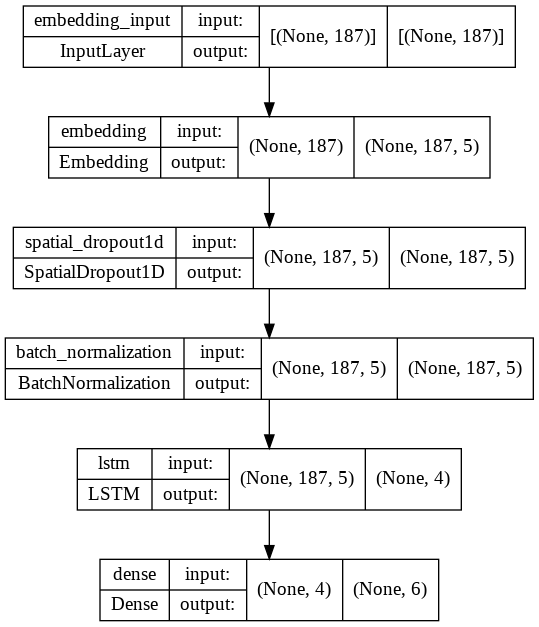

In [20]:
# Создадим экземпляр модели нейронной сети
LSTM_Model = Create_LSTM_Model(5, maxLenData)
# и построим график для визуализации слоев и связей между ними
plot_model(LSTM_Model, to_file='LSTM_Model.png', show_shapes=True) 

In [21]:
# Обучаем сеть с указанием обучающей выборки, количества эпох, размера минибатча для подачи сети, и размера валидационной выборки
history_LSTM_Model = LSTM_Model.fit(trainX_ForInput, trainY_OHE, epochs=100, batch_size=200, validation_split=0.2)

Epoch 1/100
85/85 [==============================] - 10s 42ms/step - loss: 1.7232 - accuracy: 0.2326 - val_loss: 1.7261 - val_accuracy: 0.2311
Epoch 2/100
85/85 [==============================] - 3s 35ms/step - loss: 1.6698 - accuracy: 0.2434 - val_loss: 1.6678 - val_accuracy: 0.2309
Epoch 3/100
85/85 [==============================] - 3s 35ms/step - loss: 1.6399 - accuracy: 0.2438 - val_loss: 1.6334 - val_accuracy: 0.2309
Epoch 4/100
85/85 [==============================] - 3s 35ms/step - loss: 1.6198 - accuracy: 0.2407 - val_loss: 1.6151 - val_accuracy: 0.2521
Epoch 5/100
85/85 [==============================] - 3s 35ms/step - loss: 1.6081 - accuracy: 0.2441 - val_loss: 1.6052 - val_accuracy: 0.2521
Epoch 6/100
85/85 [==============================] - 3s 35ms/step - loss: 1.6018 - accuracy: 0.2382 - val_loss: 1.5999 - val_accuracy: 0.2521
Epoch 7/100
85/85 [==============================] - 3s 35ms/step - loss: 1.5981 - accuracy: 0.2412 - val_loss: 1.5970 - val_accuracy: 0.2309
Epoch

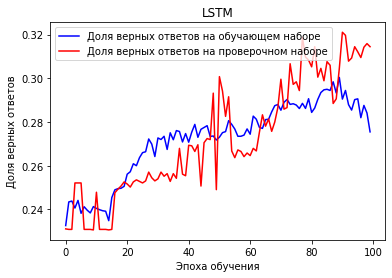

In [22]:
Plot_train_history(history_LSTM_Model, 'LSTM')

In [23]:
LSTM_Model.save('/content/drive/My Drive/datasets/LSTM_Conv1D/LSTM_Model.h5') # сохраним модель по необходимости
# LSTM_Model = load_model('/content/drive/My Drive/datasets/LSTM_Conv1D/LSTM_Model.h5') # загрузим модель по необходимости

Bidirectional

In [24]:
def Create_Bidirectional_Model(embeding_size, maxLenData, maxWordsCount = 10000):
    modelEL = Sequential() # создаём последовательную модель нейросети

    # преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
    modelEL.add(Embedding(maxWordsCount, embeding_size, input_length=maxLenData ))

    modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
    modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
    modelEL.add(Bidirectional(LSTM(4)))
    modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

    # Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
    modelEL.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return modelEL

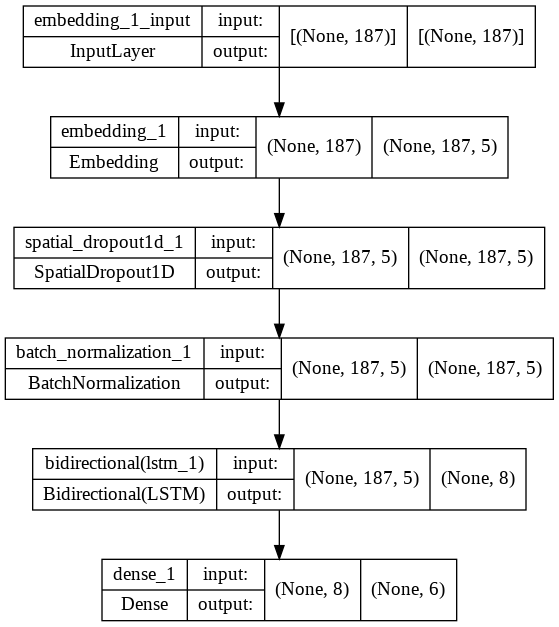

In [25]:
# Создадим экземпляр модели нейронной сети
Bidirectional_Model = Create_Bidirectional_Model(5, maxLenData)
# и построим график для визуализации слоев и связей между ними
plot_model(Bidirectional_Model, to_file='Bidirectional_Model.png', show_shapes=True) 

In [26]:
# Обучаем сеть с указанием обучающей выборки, количества эпох, размера минибатча для подачи сети, и размера валидационной выборки
history_Bidirectional_Model = Bidirectional_Model.fit(trainX_ForInput, trainY_OHE, epochs=100, batch_size=160, validation_split=0.2)

Epoch 1/100
106/106 [==============================] - 13s 83ms/step - loss: 1.6415 - accuracy: 0.2528 - val_loss: 1.6281 - val_accuracy: 0.2443
Epoch 2/100
106/106 [==============================] - 8s 74ms/step - loss: 1.5138 - accuracy: 0.3407 - val_loss: 1.5999 - val_accuracy: 0.2344
Epoch 3/100
106/106 [==============================] - 8s 73ms/step - loss: 1.4087 - accuracy: 0.3901 - val_loss: 1.6303 - val_accuracy: 0.2533
Epoch 4/100
106/106 [==============================] - 8s 74ms/step - loss: 1.3403 - accuracy: 0.4170 - val_loss: 1.5806 - val_accuracy: 0.2908
Epoch 5/100
106/106 [==============================] - 8s 72ms/step - loss: 1.2862 - accuracy: 0.4395 - val_loss: 1.3801 - val_accuracy: 0.3699
Epoch 6/100
106/106 [==============================] - 8s 73ms/step - loss: 1.2470 - accuracy: 0.4593 - val_loss: 1.3386 - val_accuracy: 0.3978
Epoch 7/100
106/106 [==============================] - 8s 73ms/step - loss: 1.2219 - accuracy: 0.4620 - val_loss: 1.2991 - val_accuracy

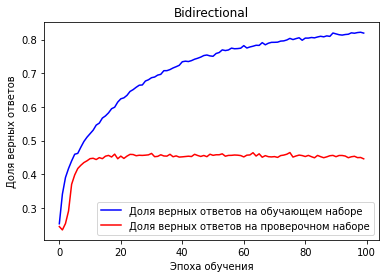

In [27]:
Plot_train_history(history_Bidirectional_Model, 'Bidirectional')

In [28]:
Bidirectional_Model.save('/content/drive/My Drive/datasets/LSTM_Conv1D/Bidirectional_Model.h5') # сохраним модель по необходимости
# Bidirectional_Model = load_model('/content/drive/My Drive/datasets/LSTM_Conv1D/Bidirectional_Model.h5') # загрузим модель по необходимости

Conv1D

In [29]:
def Create_Conv1D_Model(embeding_size, maxLenData, maxWordsCount = 10000):
    modelEC = Sequential() # создаём последовательную модель нейросети

    # преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
    modelEC.add(Embedding(maxWordsCount, embeding_size, input_length=maxLenData ))

    modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
    modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
    modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
    modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
    modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
    modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
    modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

    # Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
    modelEC.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return modelEC

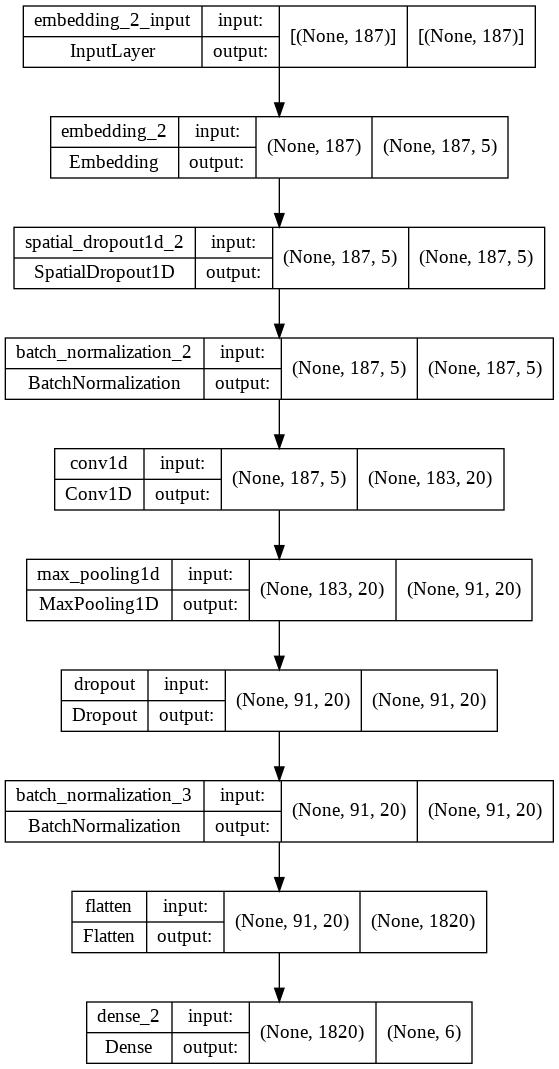

In [30]:
# Создадим экземпляр модели нейронной сети
Conv1D_Model = Create_Conv1D_Model(5, maxLenData)
# и построим график для визуализации слоев и связей между ними
plot_model(Conv1D_Model, to_file='Conv1D_Model.png', show_shapes=True) 

In [31]:
# Обучаем сеть с указанием обучающей выборки, количества эпох, размера минибатча для подачи сети, и размера валидационной выборки
history_Conv1D_Model = Conv1D_Model.fit(trainX_ForInput, trainY_OHE, epochs=100, batch_size=160, validation_split=0.2)

Epoch 1/100
106/106 [==============================] - 9s 16ms/step - loss: 1.8964 - accuracy: 0.2182 - val_loss: 1.6507 - val_accuracy: 0.1759
Epoch 2/100
106/106 [==============================] - 1s 9ms/step - loss: 1.5820 - accuracy: 0.3127 - val_loss: 1.7299 - val_accuracy: 0.1759
Epoch 3/100
106/106 [==============================] - 1s 9ms/step - loss: 1.3480 - accuracy: 0.4099 - val_loss: 1.6173 - val_accuracy: 0.1917
Epoch 4/100
106/106 [==============================] - 1s 9ms/step - loss: 1.1963 - accuracy: 0.4813 - val_loss: 1.4442 - val_accuracy: 0.3631
Epoch 5/100
106/106 [==============================] - 1s 10ms/step - loss: 1.1030 - accuracy: 0.5316 - val_loss: 1.3914 - val_accuracy: 0.3728
Epoch 6/100
106/106 [==============================] - 1s 10ms/step - loss: 1.0286 - accuracy: 0.5663 - val_loss: 1.2665 - val_accuracy: 0.4259
Epoch 7/100
106/106 [==============================] - 1s 10ms/step - loss: 0.9547 - accuracy: 0.6031 - val_loss: 1.2891 - val_accuracy: 0.

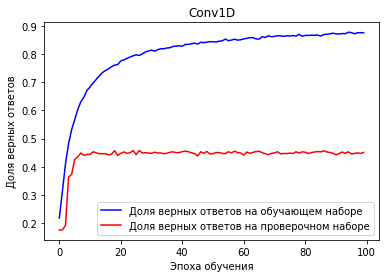

In [32]:
Plot_train_history(history_Conv1D_Model, 'Conv1D')

In [33]:
Conv1D_Model.save('/content/drive/My Drive/datasets/LSTM_Conv1D/Conv1D_Model2.h5') # сохраним модель по необходимости
# Conv1D_Model = load_model('/content/drive/My Drive/datasets/LSTM_Conv1D/Conv1D_Model2.h5') # загрузим модель по необходимости

In [34]:
# Собираем статистический результат предикта
def Create_predict_model(Model_test, testX_ForInput):
    try:
        Output_FortestX = np.argmax(Model_test.predict(testX_ForInput),axis=-1)
        print('Данные успешно сформированы!')
    except:
        print('Попытка сформировать предсказанные данные не удалась!')
    return Output_FortestX

In [35]:
# оформить результат и отправить на Kaggle
def Send_results(pred_data_my):
    try:
        predUnscaled = pred_data_my.squeeze()
        # создаём датафрейм в нужном формате
        submission = pd.DataFrame({"Id":range(1,len(predUnscaled)+1),"Label":predUnscaled})
        
        #submission.head()
        # сохраняем его как csv
        submission = submission.to_csv('./Submission_review_phone.csv', sep=',', index=False, header=True)
        # отправляем на соревнование
        !kaggle competitions submit -c rnn-ccn-for-text-udt-3 -f Submission_review_phone.csv -m "Message"
        print('\n Расчитанные данные успешно отправлены! ')
    except:
        print('Отправка расчетных данных не прошла! ')  

In [36]:
# сформируем результат предсказания, на заданной модели
prediction_data = Create_predict_model(Conv1D_Model, testX_ForInput)

Данные успешно сформированы!


In [37]:
Send_results(prediction_data) # оформить результат и отправить на Kaggle

100% 24.5k/24.5k [00:05<00:00, 4.25kB/s]
Successfully submitted to Университет Цифровых Технологий платформа 3
 Расчитанные данные успешно отправлены! 


###Переходим по ссылке, чтобы увидеть таблицу лидеров.

https://www.kaggle.com/c/rnn-ccn-for-text-udt-3/leaderboard